# Active Inference model inversion: T-Maze Environment

In [1]:
import jax.numpy as jnp

import seaborn as sns
import matplotlib.pyplot as plt

from pymdp.jax.agent import Agent as AIFAgent
from pymdp.envs import TMazeEnv

In [ ]:
from pybefit import ModelInference

def param_transform(z):
    init = {}  # define some initial values of random variables that should be infered
    params = {}  # define parameters that should be infered
    return init, params


# we could simplify the interface so that AIFAgent class is constructed as 
# aif_agent = AIFAgent(init_variables, params, options)

# define some static options for the AIFAgent class
agent_options = {

}

# define properties of inference
inference_options = {
    # e.g. method can be svi or nuts
    'method': 'SVI',
    # different forms of the parameteric prior, such as, NormalGamma, NormalHorseshoe, NormalRegularizedHorseshoe
    'prior': 'NormalGamma',
    # hierachical inference with group level 
    'type': 'Hierarchical',

}

inference = ModelInference(AIFAgent, agent_options, inference_options)

num_samples = 1000
max_iterations = 1000
tolerance = 1e-3
# optimizer options
opts = {
    'learning_rate': 1e-3
}

inference.fit(behavioural_data, num_samples, max_iterations, tolerance, opts)

### Auxiliary Functions

Define some utility functions that will be helpful for plotting.

In [2]:
def plot_beliefs(belief_dist, title=""):
    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title)
    plt.show()
    
def plot_likelihood(A, title=""):
    sns.heatmap(A, cmap="OrRd", linewidth=2.5)
    plt.xticks(range(A.shape[1]))
    plt.yticks(range(A.shape[0]))
    plt.title(title)
    plt.show()

## Environment

Here we consider an agent navigating a three-armed 'T-maze,' with the agent starting in a central location of the maze. The bottom arm of the maze contains an informative cue, which signals in which of the two top arms ('Left' or 'Right', the ends of the 'T') a reward is likely to be found. 

At each timestep, the environment is described by the joint occurrence of two qualitatively-different 'kinds' of states (hereafter referred to as _hidden state factors_). These hidden state factors are independent of one another.

We represent the first hidden state factor (`Location`) as a $ 1 \ x \ 4 $ vector that encodes the current position of the agent, and can take the following values: {`CENTER`, `RIGHT ARM`, `LEFT ARM`, or `CUE LOCATION`}. For example, if the agent is in the `CUE LOCATION`, the current state of this factor would be $s_1 = [0 \ 0 \ 0 \ 1]$.

We represent the second hidden state factor (`Reward Condition`) as a $ 1 \ x \ 2 $ vector that encodes the reward condition of the trial: {`Reward on Right`, or `Reward on Left`}.  A trial where the condition is reward is `Reward on Left` is thus encoded as the state $s_2 = [0 \ 1]$.

The environment is designed such that when the agent is located in the `RIGHT ARM` and the reward condition is `Reward on Right`, the agent has a specified probability $a$ (where $a > 0.5$) of receiving a reward, and a low probability $b = 1 - a$ of receiving a 'loss' (we can think of this as an aversive or unpreferred stimulus). If the agent is in the `LEFT ARM` for the same reward condition, the reward probabilities are swapped, and the agent experiences loss with probability $a$, and reward with lower probability $b = 1 - a$. These reward contingencies are intuitively swapped for the `Reward on Left` condition. 

For instance, we can encode the state of the environment at the first time step in a `Reward on Right` trial with the following pair of hidden state vectors: $s_1 = [1 \ 0 \ 0 \ 0]$, $s_2 = [1 \ 0]$, where we assume the agent starts sitting in the central location. If the agent moved to the right arm, then the corresponding hidden state vectors would now be $s_1 = [0 \ 1 \ 0 \ 0]$, $s_2 = [1 \ 0]$. This highlights the _independence_ of the two hidden state factors -- the location of the agent ($s_1$) can change without affecting the identity of the reward condition ($s_2$).


### 1. Initialize environment
Now we can initialize the T-maze environment using the built-in `TMazeEnv` class from the `pymdp.envs` module.

Choose reward probabilities $a$ and $b$, where $a$ and $b$ are the probabilities of reward / loss in the 'correct' arm, and the probabilities of loss / reward in the 'incorrect' arm. Which arm counts as 'correct' vs. 'incorrect' depends on the reward condition (state of the 2nd hidden state factor).

In [3]:
reward_probabilities = [0.98, 0.02] # probabilities used in the original SPM T-maze demo

Initialize an instance of the T-maze environment

In [4]:
env = TMazeEnv(reward_probs = reward_probabilities)

### Structure of the state --> outcome mapping
We can 'peer into' the rules encoded by the environment (also known as the _generative process_ ) by looking at the probability distributions that map from hidden states to observations. Following the SPM version of active inference, we refer to this collection of probabilistic relationships as the `A` array. In the case of the true rules of the environment, we refer to this array as `A_gp` (where the suffix `_gp` denotes the generative process). 

It is worth outlining what constitute the agent's observations in this task. In this T-maze demo, we have three sensory channels or observation modalities: `Location`, `Reward`, and `Cue`. 

>The `Location` observation values are identical to the `Location` hidden state values. In this case, the agent always unambiguously observes its own state - if the agent is in `RIGHT ARM`, it receives a `RIGHT ARM` observation in the corresponding modality. This might be analogized to a 'proprioceptive' sense of one's own place.

>The `Reward` observation modality assumes the values `No Reward`, `Reward` or `Loss`. The `No Reward` (index 0) observation is  observed whenever the agent isn't occupying one of the two T-maze arms (the right or left arms). The `Reward` (index 1) and `Loss` (index 2) observations are observed in the right and left arms of the T-maze, with associated probabilities that depend on the reward condition (i.e. on the value of the second hidden state factor).

> The `Cue` observation modality assumes the values `Cue Right`, `Cue Left`. This observation unambiguously signals the reward condition of the trial, and therefore in which arm the `Reward` observation is more probable. When the agent occupies the other arms, the `Cue` observation will be `Cue Right` or `Cue Left` with equal probability. However (as we'll see below when we intialise the agent), the agent's beliefs about the likelihood mapping render these observations uninformative and irrelevant to state inference.

In `pymdp`, we store the set of probability distributions encoding the conditional probabilities of observations, under different configurations of hidden states, as a set of matrices referred to as the likelihood mapping or `A` array (this is a convention borrowed from SPM). The likelihood mapping _for a single modality_ is stored as a single matrix `A[i]` with the larger likelihood array, where `i` is the index of the corresponding modality. Each modality-specific A matrix has `n_observations[i]` rows, and as many lagging dimensions (e.g. columns, 'slices' and higher-order dimensions) as there are hidden state factors. `n_observations[i]` tells you the number of observation values for observation modality `i`, and is usually stored as a property of the `Env` class (e.g. `env.n_observations`).



In [5]:
A_gp = env.get_likelihood_dist()

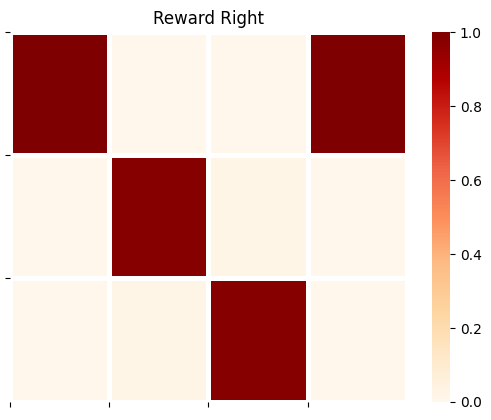

In [6]:
plot_likelihood(A_gp[1][:, :, 0],'Reward Right')

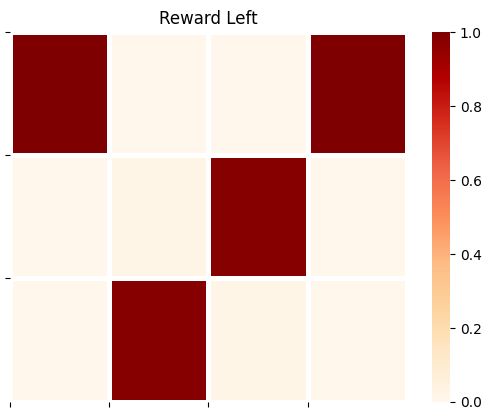

In [7]:
plot_likelihood(A_gp[1][:, :, 1],'Reward Left')

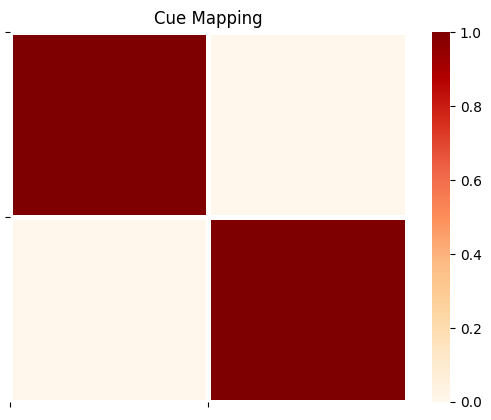

In [8]:
plot_likelihood(A_gp[2][:, 3, :],'Cue Mapping')

### Transition Dynamics

We represent the dynamics of the environment (e.g. changes in the location of the agent and changes to the reward condition) as conditional probability distributions that encode the likelihood of transitions between the states of a given hidden state factor. These distributions are collected into the so-called `B` array, also known as _transition likelihoods_ or _transition distribution_ . As with the `A` array, we denote the true probabilities describing the environmental dynamics as `B_gp`. Each sub-matrix `B_gp[f]` of the larger array encodes the transition probabilities between state-values of a given hidden state factor with index `f`. These matrices encode dynamics as Markovian transition probabilities, such that the entry $i,j$ of a given matrix encodes the probability of transition to state $i$ at time $t+1$, given state $j$ at $t$. 

In [9]:
B_gp = env.get_transition_dist()

For example, we can inspect the 'dynamics' of the `Reward Condition` factor by indexing into the appropriate sub-matrix of `B_gp`

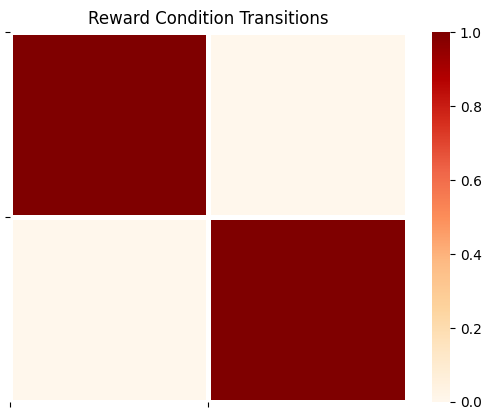

In [10]:
plot_likelihood(B_gp[1][:, :, 0],'Reward Condition Transitions')

The above transition array is the 'trivial' identity matrix, meaning that the reward condition doesn't change over time (it's mapped from whatever it's current value is to the same value at the next timestep).

### (Controllable-) Transition Dynamics

Importantly, some hidden state factors are _controllable_ by the agent, meaning that the probability of being in state $i$ at $t+1$ isn't merely a function of the state at $t$, but also of actions (or from the agent's perspective, _control states_ ). So now each transition likelihood encodes conditional probability distributions over states at $t+1$, where the conditioning variables are both the states at $t-1$ _and_ the actions at $t-1$. This extra conditioning on actions is encoded via an optional third dimension to each factor-specific `B` matrix.

For example, in our case the first hidden state factor (`Location`) is under the control of the agent, which means the corresponding transition likelihoods `B[0]` are index-able by both previous state and action.

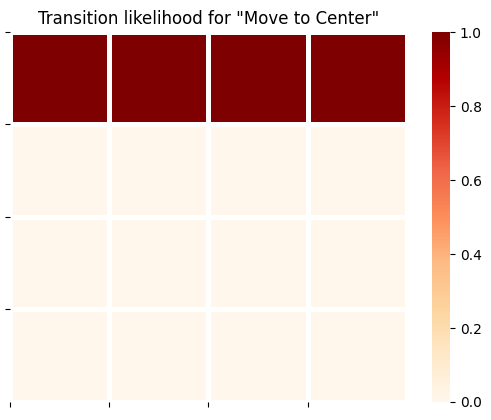

In [11]:
plot_likelihood(B_gp[0][:,:,0],'Transition likelihood for "Move to Center"')

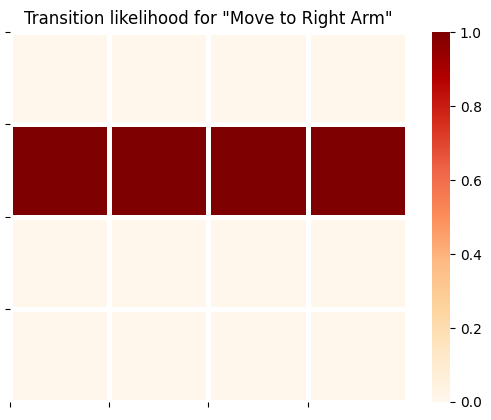

In [12]:
plot_likelihood(B_gp[0][:,:,1],'Transition likelihood for "Move to Right Arm"')

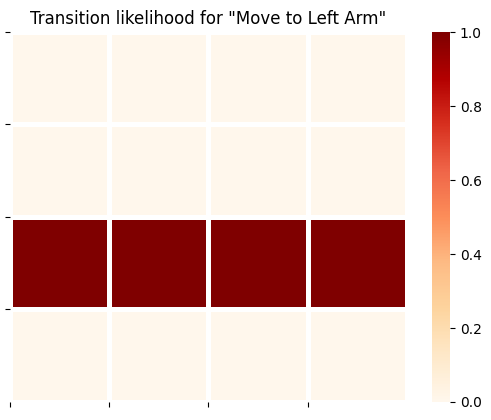

In [13]:
plot_likelihood(B_gp[0][:,:,2],'Transition likelihood for "Move to Left Arm"')

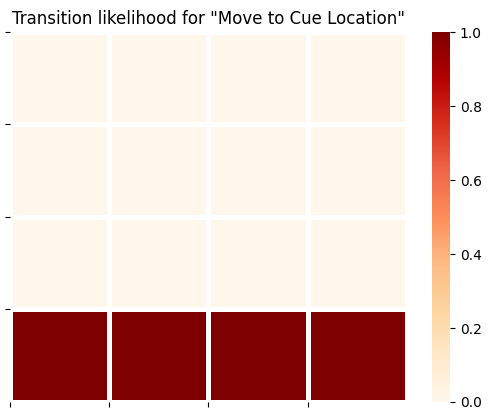

In [14]:
plot_likelihood(B_gp[0][:,:,3],'Transition likelihood for "Move to Cue Location"')

## The generative model
Now we can move onto setting up the generative model of the agent - namely, the agent's beliefs about how hidden states give rise to observations, and how hidden states transition among eachother.

In almost all MDPs, the critical building blocks of this generative model are the agent's representation of the observation likelihood, which we'll refer to as `A_gm`, and its representation of the transition likelihood, or `B_gm`. 

Here, we assume the agent has a veridical representation of the rules of the T-maze (namely, how hidden states cause observations) as well as its ability to control its own movements with certain consequences (i.e. 'noiseless' transitions).

In [15]:
num_agents = 50  # number of different agents 
A_gm = [jnp.broadcast_to(jnp.array(a), (num_agents,) + a.shape) for a in A_gp]  # map the true observation likelihood to jax arrays
B_gm = [jnp.broadcast_to(jnp.array(b), (num_agents,) + b.shape) for b in B_gp]  # map the true transition likelihood to jax arrays
D_gm = [jnp.broadcast_to(jnp.array([1., 0., 0., 0.]), (num_agents, 4)), jnp.broadcast_to(jnp.array([.5, .5]), (num_agents, 2))]
C_gm = [jnp.zeros((num_agents, 4)), jnp.broadcast_to(jnp.array([0., -3., 3.]), (num_agents, 3)),jnp.zeros((num_agents, 2))]
E_gm = jnp.ones((num_agents, 4))

###  Note !
It is not necessary, or even in many cases _important_ , that the generative model is a veridical representation of the generative process. This distinction between generative model (essentially, beliefs entertained by the agent and its interaction with the world) and the generative process (the actual dynamical system 'out there' generating sensations) is of crucial importance to the active inference formalism and (in our experience) often overlooked in code.

It is for notational and computational convenience that we encode the generative process using `A` and `B` matrices. By doing so, it simply puts the rules of the environment in a data structure that can easily be converted into the Markovian-style conditional distributions useful for encoding the agent's generative model.

Strictly speaking, however, all the generative process needs to do is generate observations and be 'perturbable' by actions. The way in which it does so can be arbitrarily complex, non-linear, and unaccessible by the agent.

## Introducing the `Agent()` class

In `pymdp`, we have abstracted much of the computations required for active inference into the `Agent()` class, a flexible object that can be used to store necessary aspects of the generative model, the agent's instantaneous observations and actions, and perform action / perception using functions like `Agent.infer_states` and `Agent.infer_policies`. 

An instance of `Agent` is straightforwardly initialized with a call to `Agent()` with a list of optional arguments.


In our call to `Agent()`, we need to constrain the default behavior with some of our T-Maze-specific needs. For example, we want to make sure that the agent's beliefs about transitions are constrained by the fact that it can only control the `Location` factor - _not_ the `Reward Condition` (which we assumed stationary across an epoch of time). Therefore we specify this using a list of indices that will be passed as the `control_fac_idx` argument of the `Agent()` constructor. 

Each element in the list specifies a hidden state factor (in terms of its index) that is controllable by the agent. Hidden state factors whose indices are _not_ in this list are assumed to be uncontrollable.

In [16]:
controllable_indices = [0] # this is a list of the indices of the hidden state factors that are controllable

Now we can construct our agent...

In [17]:
agent = Agent(A_gm, B_gm, C_gm, D_gm, E_gm, control_fac_idx=controllable_indices)

In [18]:
policies = jnp.stack(agent.policies)
print(policies.shape)
print(policies.dtype)

(4, 1, 2)
int32


In [19]:
import jax.tree_util as jtu

vals, tree = jtu.tree_flatten(agent)

print(tree)

PyTreeDef(CustomNode(Agent[(('A', 'B', 'C', 'D', 'E', 'gamma', 'qs', 'q_pi'), ('num_obs', 'num_modalities', 'num_states', 'num_factors', 'num_controls', 'inference_algo', 'control_fac_idx', 'policy_len', 'policies', 'use_utility', 'use_states_info_gain', 'use_param_info_gain', 'action_selection'), ([4, 3, 2], 3, [4, 2], 2, [4, 1], 'VANILLA', [0], 1, DeviceArray([[[0, 0]],

             [[1, 0]],

             [[2, 0]],

             [[3, 0]]], dtype=int32), True, True, False, 'deterministic'))], [[*, *, *], [*, *], [*, *, *], [*, *], *, *, None, None]))


## Active Inference
Now we can start off the T-maze with an initial observation and run active inference via a loop over a desired time interval.

In [20]:
T = 5 # number of timesteps

emp_prior = D_gm
_obs = env.reset() # reset the environment and get an initial observation
obs = jnp.broadcast_to(jnp.array(_obs), (num_agents, len(_obs)))

# these are useful for displaying read-outs during the loop over time
reward_conditions = ["Right", "Left"]
location_observations = ['CENTER','RIGHT ARM','LEFT ARM','CUE LOCATION']
reward_observations = ['No reward','Reward!','Loss!']
cue_observations = ['Cue Right','Cue Left']
msg = """ === Starting experiment === \n Reward condition: {}, Observation: [{}, {}, {}]"""
print(msg.format(reward_conditions[env.reward_condition], location_observations[_obs[0]], reward_observations[_obs[1]], cue_observations[_obs[2]]))

measurements = {'actions': [], 'outcomes': [obs]}
for t in range(T):
    qs = agent.infer_states(obs, emp_prior)

    q_pi, efe = agent.infer_policies(qs)

    actions = agent.sample_action(q_pi)
    emp_prior = agent.update_empirical_prior(actions, qs)

    measurements["actions"].append( actions )
    msg = """[Step {}] Action: [Move to {}]"""
    print(msg.format(t, location_observations[int(actions[0, 0])]))

    obs = []
    for a in actions:
        obs.append( jnp.array(env.step(list(a))) )
    obs = jnp.stack(obs)
    measurements["outcomes"].append(obs)

    msg = """[Step {}] Observation: [{},  {}, {}]"""
    print(msg.format(t, location_observations[obs[0, 0]], reward_observations[obs[0, 1]], cue_observations[obs[0, 2]]))
    
measurements['actions'] = jnp.stack(measurements['actions']).astype(jnp.int32)
measurements['outcomes'] = jnp.stack(measurements['outcomes'])

measurements['outcomes'] = measurements['outcomes'][None, :T]
measurements['actions'] = measurements['actions'][None]

 === Starting experiment === 
 Reward condition: Right, Observation: [CENTER, No reward, Cue Left]
[Step 0] Action: [Move to RIGHT ARM]
[Step 0] Observation: [RIGHT ARM,  Reward!, Cue Right]
[Step 1] Action: [Move to CUE LOCATION]
[Step 1] Observation: [CUE LOCATION,  No reward, Cue Right]
[Step 2] Action: [Move to LEFT ARM]
[Step 2] Observation: [LEFT ARM,  Loss!, Cue Left]
[Step 3] Action: [Move to CUE LOCATION]
[Step 3] Observation: [CUE LOCATION,  No reward, Cue Right]
[Step 4] Action: [Move to LEFT ARM]
[Step 4] Observation: [LEFT ARM,  Reward!, Cue Right]


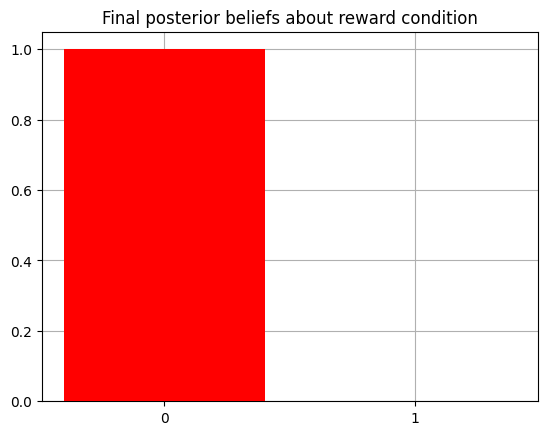

In [21]:
plot_beliefs(qs[1][0],"Final posterior beliefs about reward condition")

# Model inversion
Define model likelihood given the observed sequence of actions and outcomes

In [33]:
import numpyro as npyro
from jax import random
from numpyro.infer import Predictive
from pymdp.jax.likelihoods import aif_likelihood, evolve_trials

print(measurements['outcomes'].shape)
print(measurements['actions'].shape)

Nb, Nt, Na, _ = measurements['actions'].shape

xs = {'outcomes': measurements['outcomes'][0], 'actions': measurements['actions'][0]}
evolve_trials(agent, xs)
%timeit evolve_trials(agent, xs)

rng_key = random.PRNGKey(0)

with npyro.handlers.seed(rng_seed=0):
    aif_likelihood(Nb, Nt, Na, measurements, agent)

%timeit pred_samples = Predictive(aif_likelihood, num_samples=11)(rng_key, Nb, Nt, Na, measurements, agent)
print(pred_samples.keys())

(1, 5, 50, 3)
(1, 5, 50, 2)
494 ms ± 6.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
172 ms ± 412 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
dict_keys(['actions', 'outcomes'])


In [59]:
import numpyro as npyro
import numpyro.distributions as dist
from jax import nn, lax, vmap

@vmap
def trans_params(z):

    a = nn.sigmoid(z[0])
    lam = nn.softplus(z[1])
    d = nn.sigmoid(z[2])

    A = lax.stop_gradient([jnp.array(x) for x in list(A_gp)])

    middle_matrix1 = jnp.array([[0., 0.], [a, 1-a], [1-a, a]])
    middle_matrix2 = jnp.array([[0., 0.], [1-a, a], [a, 1-a]])

    side_vector = jnp.stack([jnp.array([1.0, 0., 0.]), jnp.array([1.0, 0., 0.])], -1)

    A[1] = jnp.stack([side_vector, middle_matrix1, middle_matrix2, side_vector], -2)
    
    C = [
        jnp.zeros(4),
        lam * jnp.array([0., 1., -1.]),
        jnp.zeros(2)
    ]

    D = [nn.one_hot(0, 4), jnp.array([d, 1-d])]

    E = jnp.ones(4)/4

    params = {
        'A': A,
        'B': lax.stop_gradient([jnp.array(x) for x in list(B_gp)]),
        'C': C,
        'D': D,
        'E': E
    }

    return  params, a, lam, d

In [61]:
def model(data, num_blocks, num_steps, num_agents, num_params=3):
    with npyro.plate('agents', num_agents):
        z = npyro.sample('z', dist.Normal(0., 1.).expand([num_params]).to_event(1))
        params, a, lmbd, d = trans_params(z)
        # register parameter values
        npyro.deterministic('a', a)
        npyro.deterministic('lambda', lmbd)
        npyro.deterministic('d', d)

    agents = Agent(
        params['A'], 
        params['B'], 
        params['C'], 
        params['D'], 
        params['E'], 
        control_fac_idx=controllable_indices
    )

    aif_likelihood(num_blocks, num_steps, num_agents, data, agents)
    
with npyro.handlers.seed(rng_seed=101111):
    model(measurements, Nb, Nt, Na)

%timeit pred_samples = Predictive(model, num_samples=11)(rng_key, measurements, Nb, Nt, Na)
print(pred_samples.keys())

357 ms ± 3.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
dict_keys(['a', 'actions', 'd', 'lambda', 'outcomes', 'z'])


In [62]:
# inference with NUTS and MCMC
from numpyro.infer import NUTS, MCMC
from numpyro.infer import init_to_feasible

rng_key = random.PRNGKey(0)
kernel = NUTS(model, init_strategy=init_to_feasible)

mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, progress_bar=False)

rng_key, _rng_key = random.split(rng_key)
mcmc.run(_rng_key, measurements, Nb, Nt, Na)

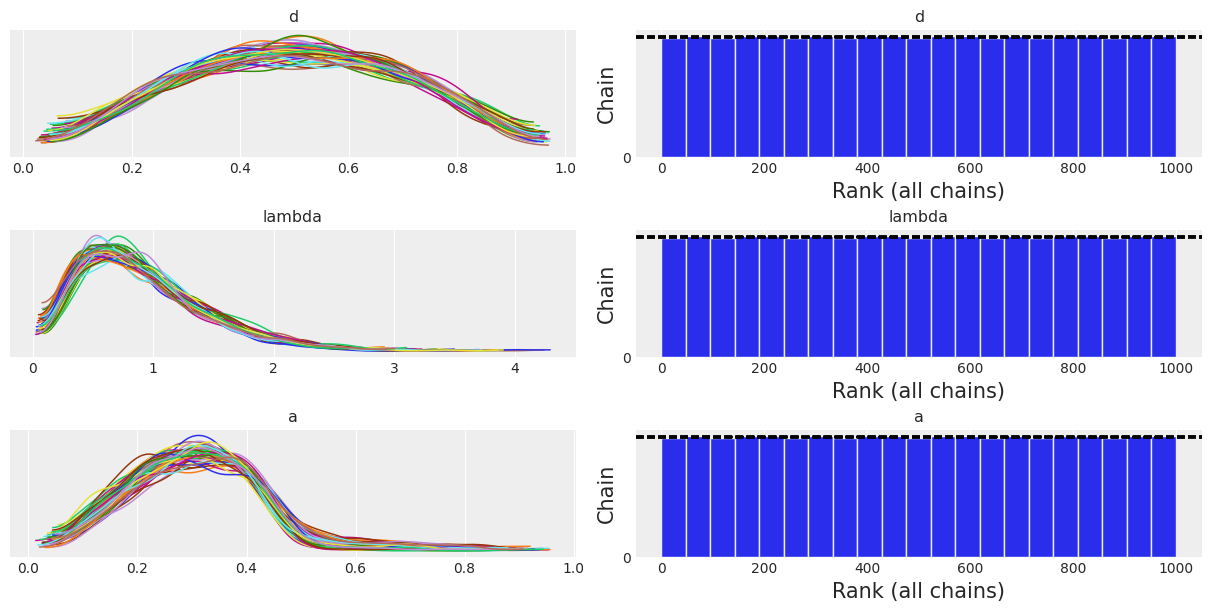

In [83]:
import arviz as az
az.style.use('arviz-darkgrid')

coords = {
    'idx': jnp.arange(num_agents),
    'vars': jnp.arange(3), 
}
dims = {'z': ["idx", "vars"], 'd': ["idx"], 'lambda': ["idx"], 'a': ["idx"]}
data_kwargs = {
    "dims": dims,
    "coords": coords,
}
data_mcmc = az.from_numpyro(posterior=mcmc, **data_kwargs)
az.plot_trace(data_mcmc, kind="rank_bars", var_names=['d', 'lambda', 'a']);

#TODO: maybe plot real values on top of samples from the posterior

In [69]:
# inferenace with SVI and autoguides
import optax
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoMultivariateNormal

num_iters = 1000
guide = AutoMultivariateNormal(model)
optimizer = npyro.optim.optax_to_numpyro(optax.chain(optax.adabelief(1e-3)))
svi = SVI(model, guide, optimizer, Trace_ELBO(num_particles=10))
rng_key, _rng_key = random.split(rng_key)
svi_res = svi.run(_rng_key, num_iters, measurements, Nb, Nt, Na, progress_bar=False)

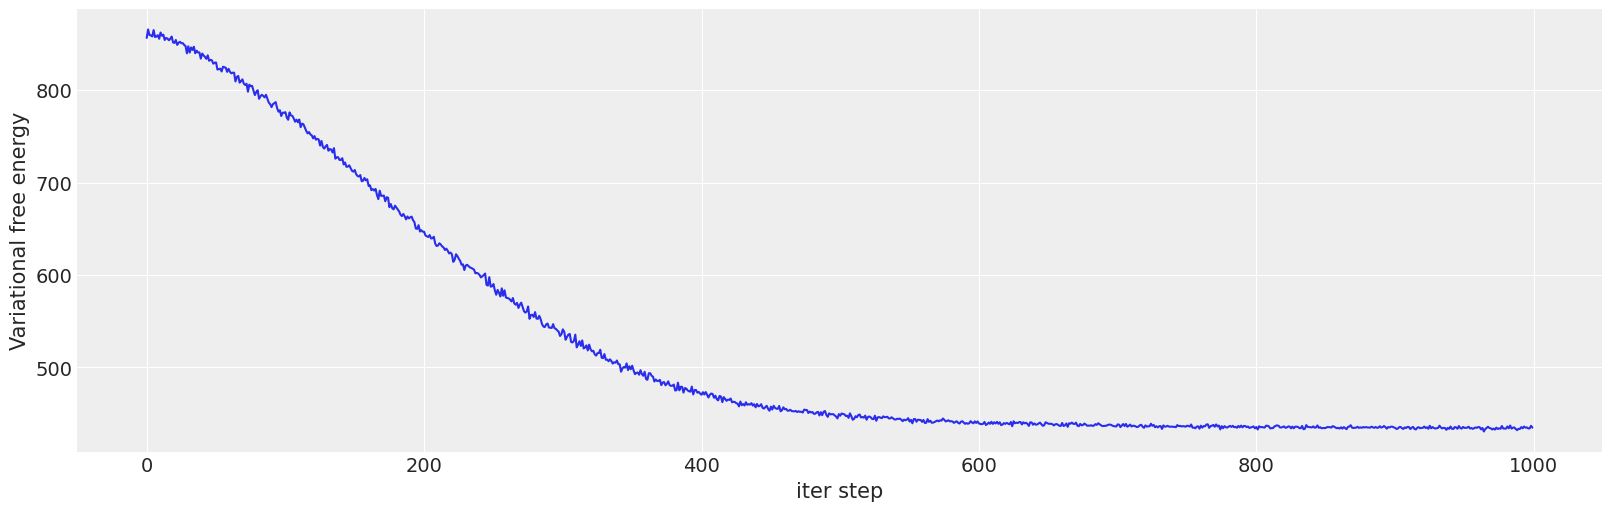

In [70]:
plt.figure(figsize=(16,5))
plt.plot(svi_res.losses)
plt.ylabel('Variational free energy')
plt.xlabel('iter step');

In [81]:
rng_key, _rng_key = random.split(rng_key)
pred = Predictive(
    model, 
    guide=guide, 
    params=svi_res.params, 
    num_samples=1000, 
    return_sites=["d", "a", "lambda"]
)
post_sample = pred(_rng_key, measurements, Nb, Nt, Na)

for key in post_sample:
    post_sample[key] = jnp.expand_dims(post_sample[key], 0)

data_svi = az.convert_to_inference_data(post_sample, group="posterior", **data_kwargs)

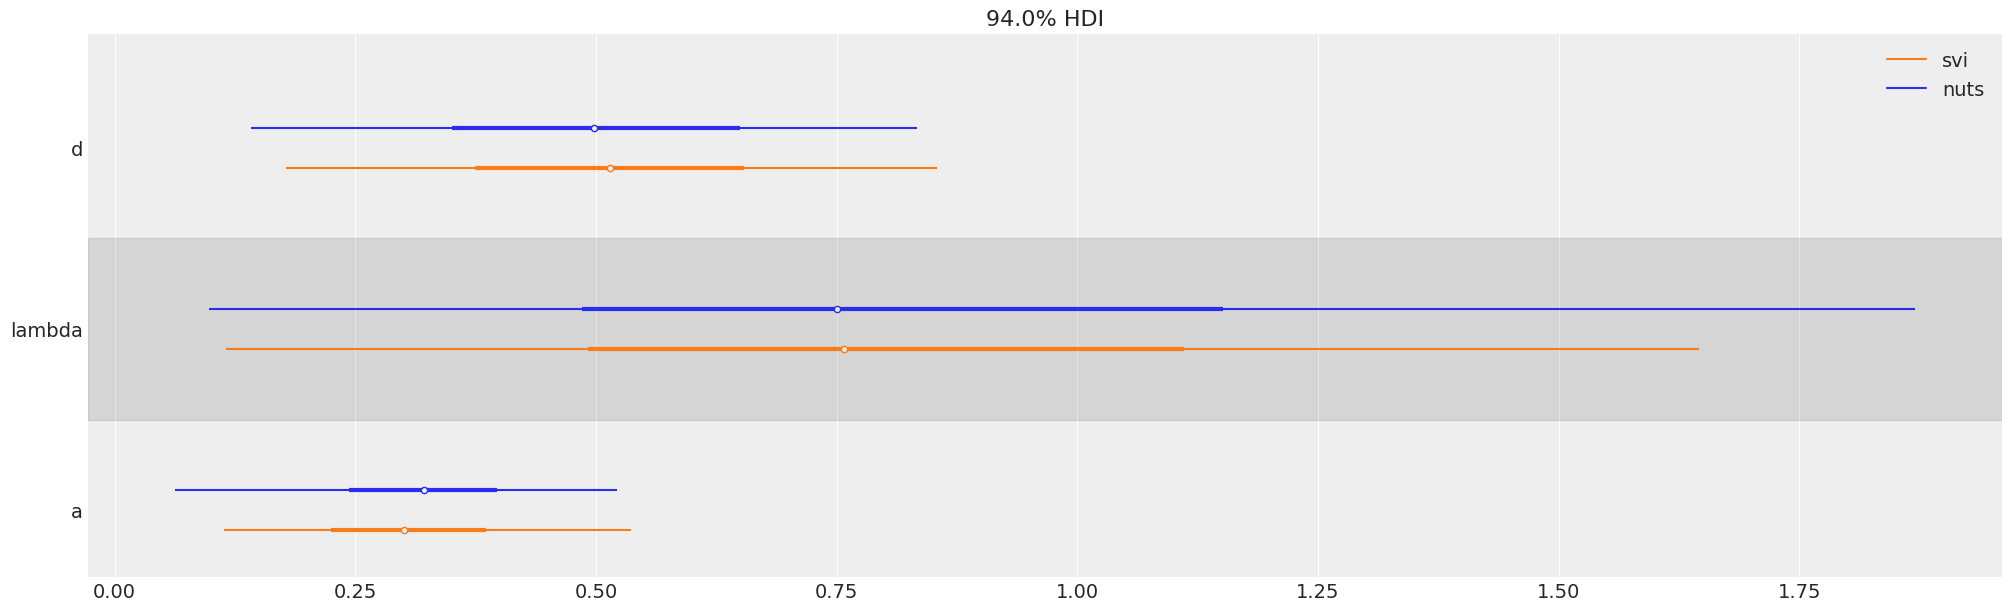

In [85]:
axes = az.plot_forest(
    [data_mcmc, data_svi],
    model_names = ["nuts", "svi"],
    kind='forestplot',
    var_names=['d', 'lambda', 'a'],
    coords={"idx": 0},
    combined=True,
    figsize=(20, 6)
)